In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
print("Dataset path:", path)
data_root = os.path.join(path, "garbage classification", "Garbage classification")

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder(root=data_root, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print("Total images:", len(dataset))
print("Classes:", dataset.classes)


Dataset path: /kaggle/input/garbage-classification
Total images: 2527
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [9]:
nz = 100  # latent vector size
netG = Generator(nz=nz).to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
fixed_noise = torch.randn(64, nz, 1, 1, device=device)


Epoch [1/10] | Loss_D: 1.0244 | Loss_G: 4.5567
Epoch [2/10] | Loss_D: 0.6829 | Loss_G: 2.0087
Epoch [3/10] | Loss_D: 0.7296 | Loss_G: 4.1570
Epoch [4/10] | Loss_D: 0.9890 | Loss_G: 5.2388
Epoch [5/10] | Loss_D: 0.7974 | Loss_G: 3.6003
Epoch [6/10] | Loss_D: 0.7593 | Loss_G: 2.5846
Epoch [7/10] | Loss_D: 0.7782 | Loss_G: 2.0717
Epoch [8/10] | Loss_D: 0.7447 | Loss_G: 2.3040
Epoch [9/10] | Loss_D: 0.6353 | Loss_G: 1.6785
Epoch [10/10] | Loss_D: 0.6798 | Loss_G: 1.6167


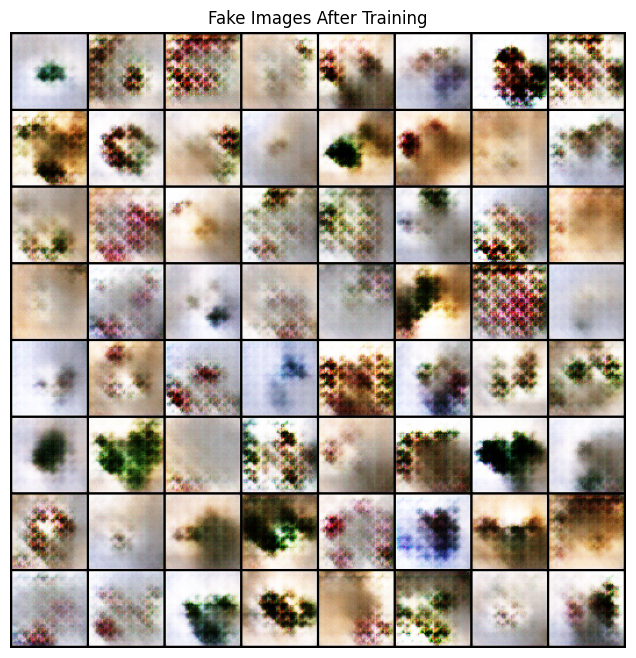

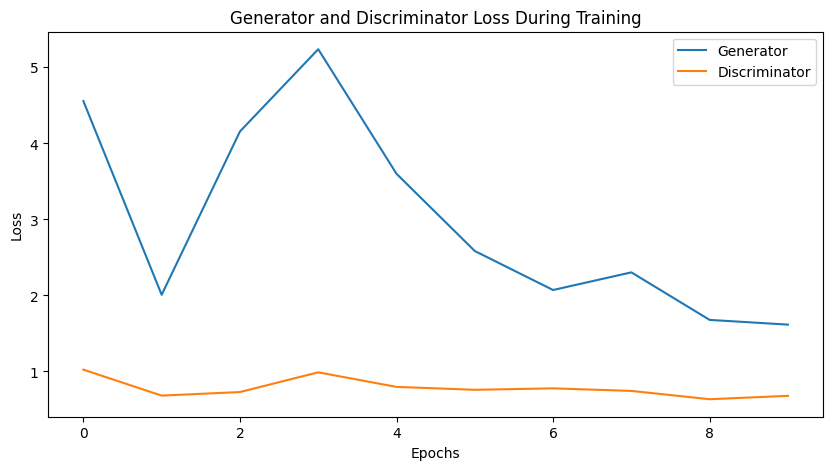

In [18]:
num_epochs = 10
img_list = []
lossesD, lossesG = [], []

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Train Discriminator
        netD.zero_grad()
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        label = torch.full((b_size,), 1., device=device)
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, label)
        lossD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0.)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(1.)
        output = netD(fake_images).view(-1)
        lossG = criterion(output, label)
        lossG.backward()
        optimizerG.step()

    # Track losses
    lossesD.append((lossD_real + lossD_fake).item())
    lossesG.append(lossG.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss_D: {(lossD_real+lossD_fake).item():.4f} | Loss_G: {lossG.item():.4f}")

    # Save generated samples for monitoring
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(utils.make_grid(fake, padding=2, normalize=True))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images After Training")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(lossesG, label="Generator")
plt.plot(lossesD, label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [19]:
os.makedirs("synthetic_waste", exist_ok=True)

with torch.no_grad():
    for i in range(200):  # generate 200 fake images
        noise = torch.randn(1, nz, 1, 1, device=device)
        fake = netG(noise).detach().cpu()
        utils.save_image(fake, f"synthetic_waste/fake_{i}.png", normalize=True)

print("Synthetic waste images generated and saved in 'synthetic_waste/'")


Synthetic waste images generated and saved in 'synthetic_waste/'
